# Sketch Generation via Diffusion Models using Sequential Strokes

This notebook implements a complete pipeline for generating sketches using Denoising Diffusion Probabilistic Models (DDPMs). We train separate models for three classes from the "Quick, Draw!" dataset: `cat`, `bus`, and `rabbit`. The entire process, from data preparation to model training, evaluation, and analysis, is contained within this document.

## 1. Approach and Design Explanation

For this task, I chose a Denoising Diffusion Probabilistic Model (DDPM). Diffusion models have recently become state-of-the-art in generative modeling, often producing higher-quality and more diverse samples than alternatives like Generative Adversarial Networks (GANs). Their training process is stable and less prone to issues like mode collapse, which is common in GANs. The core idea of systematically adding noise to an image and then training a model to reverse the process is both elegant and powerful for learning complex data distributions.

### Method Implemented

The implementation is based on the original DDPM paper. The process involves:
1.  **Forward Process:** Gradually add Gaussian noise to the input images over a series of timesteps.
2.  **Reverse Process:** Train a U-Net model to predict the noise added at each timestep, conditioned on the noisy image and the timestep.
3.  **Sampling:** To generate a new image, we start with pure noise and iteratively apply the trained model to denoise it over the same number of timesteps.

Due to the distinct nature of each class, I opted to train a separate, specialized model for each category (`cat`, `bus`, `rabbit`). This is a simple but effective form of conditioning, where the model's entire capacity is dedicated to learning the distribution of a single class.

### Alternatives Considered

-   **Generative Adversarial Networks (GANs):** GANs are known for fast sampling but suffer from training instability, mode collapse, and can be difficult to tune. For a task requiring high-fidelity sketch generation, the stability of diffusion models is a significant advantage.
-   **Variational Autoencoders (VAEs):** VAEs are generally stable and provide a probabilistic latent space, but often produce blurrier and less detailed images compared to modern GANs or diffusion models.

### Advantages and Limitations

**Advantages:**
-   **High-Quality Samples:** Diffusion models are capable of generating very high-quality and diverse images.
-   **Training Stability:** The training objective (predicting noise) is straightforward and stable.
-   **Diversity:** The stochastic nature of the sampling process leads to a wide variety of generated outputs.

**Limitations/Drawbacks:**
-   **Slow Sampling:** The iterative denoising process is computationally expensive and slow, requiring hundreds or thousands of steps to generate a single image.
-   **Computational Cost:** Training can be resource-intensive, although the lightweight U-Net used here mitigates this to some extent.
-   **Rasterization:** My approach converts vector strokes into raster images. This loses the sequential, stroke-based information, which could be leveraged by a more complex model (e.g., a Recurrent Neural Network). The generated "stroke-by-stroke" GIF is a visualization of the denoising process, not a true sequential stroke generation.

## 2. Data Preparation

This section covers all steps to prepare the "Quick, Draw!" dataset for training. We will install dependencies, load the data, create train/test splits if they don't exist, and set up PyTorch `Dataset` and `DataLoader` objects.

In [1]:
# Install required dependencies
!pip install -q ndjson torch torchvision pillow imageio matplotlib torch-fidelity

In [ ]:
import os
import json
import random
import ndjson
import numpy as np
import imageio
import urllib.request

import torch
import torch.nn as nn
import torch.nn.functional as nn_F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.utils import make_grid


from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

# --- Configuration ---
SEED = 42
IMAGE_SIZE = 64
BATCH_SIZE = 128
CLASSES = ["cat", "bus", "rabbit"]
DATA_DIR = "data/quickdraw"
OUTPUT_DIR = "outputs"
EPOCHS = 50 
LEARNING_RATE = 1e-3

# --- Reproducibility ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

PyTorch version: 2.7.1+cu126
Device: cuda


### Loading Data and Creating Splits

We will now load the `.ndjson` files. For each class, we check if a `train/test` split file (`indices.json`) exists. If not, we create a 90/10 split, save it to disk, and print a confirmation. This ensures that the same splits are used for all subsequent runs.

In [3]:
# --- Data Download ---
base_url = "https://storage.googleapis.com/quickdraw_dataset/full/simplified/"
os.makedirs(DATA_DIR, exist_ok=True)

for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    file_path = os.path.join(DATA_DIR, f"{class_name}.ndjson")
    if not os.path.exists(file_path):
        print(f"Downloading {class_name}.ndjson...")
        url = f"{base_url}{class_name}.ndjson"
        urllib.request.urlretrieve(url, file_path)
    else:
        print(f"{class_name}.ndjson already exists.")

# --- Data Loading and Split Creation ---
all_data = {}
for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    indices_path = os.path.join(class_dir, "indices.json")
    ndjson_path = os.path.join(DATA_DIR, f"{class_name}.ndjson")

    with open(ndjson_path) as f:
        drawings = ndjson.load(f)

    if os.path.exists(indices_path):
        print(f"Loading existing train/test split for {class_name}...")
        with open(indices_path, 'r') as f:
            indices = json.load(f)
    else:
        print(f"Creating train/test split for {class_name}...")
        num_samples = len(drawings)
        all_indices = list(range(num_samples))
        random.shuffle(all_indices)
        split_point = int(0.9 * num_samples)
        indices = {
            "train": all_indices[:split_point],
            "test": all_indices[split_point:]
        }
        with open(indices_path, 'w') as f:
            json.dump(indices, f)
        print(f"Saved indices to {indices_path}")

    all_data[class_name] = {
        "train_drawings": [drawings[i] for i in indices["train"]],
        "test_drawings": [drawings[i] for i in indices["test"]],
    }
    print(f"Loaded {len(all_data[class_name]['train_drawings'])} train and {len(all_data[class_name]['test_drawings'])} test samples for {class_name}.")

cat.ndjson already exists.
bus.ndjson already exists.
rabbit.ndjson already exists.
Loading existing train/test split for cat...
Loaded 10000 train and 2000 test samples for cat.
Loading existing train/test split for cat...
Loaded 10000 train and 2000 test samples for cat.
Loading existing train/test split for bus...
Loaded 10000 train and 2000 test samples for bus.
Loading existing train/test split for bus...
Loaded 10000 train and 2000 test samples for bus.
Loading existing train/test split for rabbit...
Loaded 10000 train and 2000 test samples for rabbit.
Loading existing train/test split for rabbit...
Loaded 10000 train and 2000 test samples for rabbit.


### Image Rendering and PyTorch Dataset

The "Quick, Draw!" data is stored as a sequence of vector strokes. To use it with a standard convolutional network like a U-Net, we must convert it into a raster image.

**Rendering Method:**
I render each drawing onto a fixed-size canvas by iterating through each stroke and drawing lines between its consecutive points. This is done using the Python Imaging Library (PIL).

**Image Size (64x64):**
I chose a `64x64` resolution. This size offers a good balance: it's large enough to capture the essential features of the sketches without being so large that it makes training computationally prohibitive for our lightweight model. A smaller size like `28x28` might lose too much detail.

The `QuickDrawDataset` class handles this rendering process and returns a normalized `[1, H, W]` tensor and its corresponding class label.

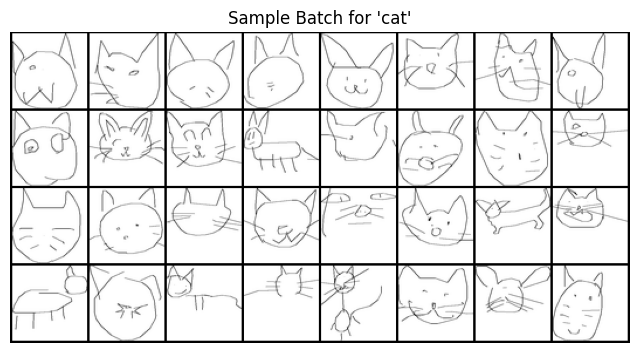

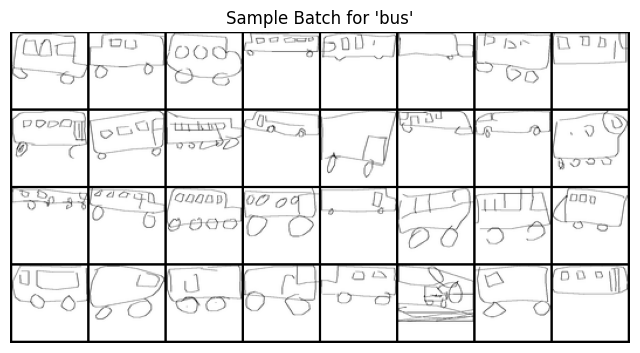

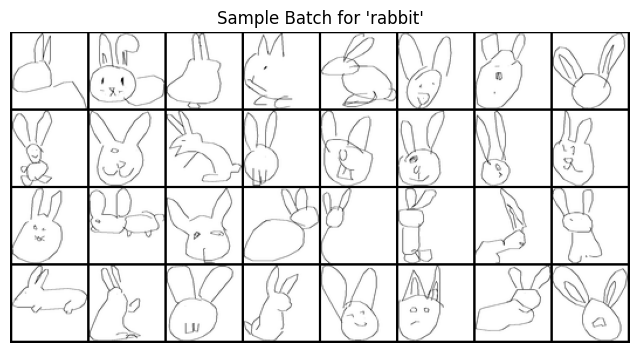

In [4]:
def strokes_to_image(strokes, img_size=IMAGE_SIZE):
    """Renders a drawing's strokes into a PIL Image."""
    image = Image.new("L", (256, 256), "white")
    draw = ImageDraw.Draw(image)
    for stroke in strokes:
        x, y = stroke
        for i in range(len(x) - 1):
            draw.line([x[i], y[i], x[i+1], y[i+1]], fill="black", width=2)
    image = image.resize((img_size, img_size), Image.Resampling.LANCZOS)
    return image

class QuickDrawDataset(Dataset):
    """PyTorch Dataset for Quick, Draw! images."""
    def __init__(self, drawings, class_label, img_size=IMAGE_SIZE):
        self.drawings = drawings
        self.class_label = class_label
        self.img_size = img_size

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        strokes = self.drawings[idx]['drawing']
        image = strokes_to_image(strokes, self.img_size)
        # Convert to tensor, normalize to [-1, 1]
        tensor = F.to_tensor(image) # [0, 1]
        tensor = F.normalize(tensor, [0.5], [0.5]) # [-1, 1]
        return tensor, self.class_label

# --- Create Datasets and DataLoaders for each class ---
dataloaders = {}
for i, class_name in enumerate(CLASSES):
    train_dataset = QuickDrawDataset(all_data[class_name]["train_drawings"], i, IMAGE_SIZE)
    test_dataset = QuickDrawDataset(all_data[class_name]["test_drawings"], i, IMAGE_SIZE)
    
    dataloaders[class_name] = {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
        "test": DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    }

# --- Visualize a batch from each class ---
def show_images(images, title=""):
    """Displays a grid of images."""
    images = (images + 1) / 2 # Denormalize from [-1, 1] to [0, 1]
    grid = make_grid(images, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.title(title)
    plt.axis('off')
    plt.show()

for class_name in CLASSES:
    sample_batch, _ = next(iter(dataloaders[class_name]["train"]))
    show_images(sample_batch[:32], title=f"Sample Batch for '{class_name}'")

## 3. Model Implementation: Conditional Diffusion Model

Here we define the core components of our Denoising Diffusion Probabilistic Model (DDPM).

### U-Net Architecture
The model's backbone is a U-Net, a convolutional autoencoder with skip connections. These connections allow the model to pass low-level feature information from the encoder to the decoder, which is crucial for preserving detail in image generation tasks. The U-Net is designed to take a noisy image and a timestep as input and predict the noise present in the image.

### Timestep Embedding
The timestep `t` is not fed directly to the model. Instead, it's converted into a fixed-size embedding using sinusoidal positional encodings, similar to those used in Transformers. This allows the model to easily distinguish between different noise levels.

### Conditioning
As mentioned, we use a simple form of conditioning: training one separate model per class. This is highly effective when the number of classes is small. The model learns the specific distribution of a single sketch type. For a larger number of classes, a more sophisticated approach like class-conditional embeddings would be necessary.

### Diffusion Logic
The `DiffusionModel` class encapsulates the entire DDPM logic:
-   **`__init__`**: Sets up the noise schedule (linear beta schedule).
-   **`forward_process`**: Adds noise to an image for a given timestep `t`.
-   **`loss`**: Computes the Mean Squared Error (MSE) between the actual noise added and the noise predicted by the U-Net.
-   **`sample`**: Implements the reverse (denoising) process to generate images from pure noise.

In [5]:
# --- U-Net Components ---

class SinusoidalPositionEmbeddings(nn.Module):
    """Converts timesteps to positional embeddings."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    """A basic convolutional block with normalization and activation."""
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SimpleUnet(nn.Module):
    """A lightweight U-Net model for the diffusion process."""
    def __init__(self, image_channels=1, down_channels=(64, 128, 256), up_channels=(256, 128, 64), time_emb_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        self.downs = nn.ModuleList([Block(image_channels, down_channels[0], time_emb_dim)])
        for i in range(len(down_channels) - 1):
            self.downs.append(Block(down_channels[i], down_channels[i+1], time_emb_dim))

        self.ups = nn.ModuleList([])
        for i in range(len(up_channels) - 1):
            self.ups.append(Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True))
        self.ups.append(Block(up_channels[-1], up_channels[-1], time_emb_dim, up=True))
        
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
        
        for up in self.ups:
            residual = residuals.pop()
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)
            
        return self.output(x)

# --- Diffusion Model Logic ---
class DiffusionModel:
    def __init__(self, timesteps=300, beta_start=1e-4, beta_end=0.02, img_size=IMAGE_SIZE, device="cpu"):
        self.timesteps = timesteps
        self.img_size = img_size
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = nn_F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def _get_index_from_list(self, vals, t, x_shape):
        batch_size = t.shape[0]
        out = vals.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(self.device)

    def forward_process(self, x_0, t):
        """Adds noise to the image x_0 at timestep t."""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self._get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)
        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

    def loss(self, model, x_0):
        """Calculates the loss for a batch of images."""
        t = torch.randint(0, self.timesteps, (x_0.shape[0],), device=self.device).long()
        x_noisy, noise = self.forward_process(x_0, t)
        predicted_noise = model(x_noisy, t)
        return nn.MSELoss()(noise, predicted_noise)

    @torch.no_grad()
    def sample(self, model, n_images):
        """Generates n_images by running the full reverse diffusion process."""
        img = torch.randn((n_images, 1, self.img_size, self.img_size), device=self.device)
        imgs = []
        for i in reversed(range(self.timesteps)):
            t = torch.full((n_images,), i, device=self.device, dtype=torch.long)
            predicted_noise = model(img, t)
            
            alpha_t = self._get_index_from_list(self.alphas, t, img.shape)
            alphas_cumprod_t = self._get_index_from_list(self.alphas_cumprod, t, img.shape)
            sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, img.shape)
            
            # Denoise step
            model_mean = (1 / torch.sqrt(alpha_t)) * (img - ((1 - alpha_t) / sqrt_one_minus_alphas_cumprod_t) * predicted_noise)
            
            if i != 0:
                posterior_variance_t = self._get_index_from_list(self.posterior_variance, t, img.shape)
                noise = torch.randn_like(img)
                img = model_mean + torch.sqrt(posterior_variance_t) * noise
            else:
                img = model_mean
            
            if i % 30 == 0: # Save intermediate steps for GIF
                imgs.append(img.cpu())
        
        return img.cpu(), imgs

## 4. Training & Inference Pipeline

Now we will train a separate diffusion model for each class: `cat`, `bus`, and `rabbit`.

For each class, the pipeline is as follows:
1.  **Setup:** Create output directories for models, images, and GIFs.
2.  **Initialization:** Instantiate the U-Net model, the diffusion logic, and an Adam optimizer.
3.  **Training Loop:** Train the model for a fixed number of epochs, printing the average loss at the end of each epoch.
4.  **Loss Visualization:** Plot and save the training loss curve.
5.  **Inference & Saving:**
    *   Generate a batch of images using the trained model.
    *   Save the generated images to `outputs/<class>/generated_images/`.
    *   Create and save an animated GIF of the denoising process to `outputs/<class>/gif/`.
    *   Save the model weights (`model.pth`) and configuration (`config.json`).

The "stroke-by-stroke" GIF mentioned in the prompt is interpreted here as a visualization of the **progressive denoising process**. Since our model operates on raster images, this is the direct equivalent of showing how the final image emerges from noise, step by step.


--- Training model for class: cat ---


Epoch 1/50 | Loss: 0.0820: 100%|██████████| 79/79 [00:13<00:00,  5.96it/s]
Epoch 1/50 | Loss: 0.0820: 100%|██████████| 79/79 [00:13<00:00,  5.96it/s]


Epoch 1/50, Average Loss: 0.1871


Epoch 2/50 | Loss: 0.0760: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
Epoch 2/50 | Loss: 0.0760: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]


Epoch 2/50, Average Loss: 0.0851


Epoch 3/50 | Loss: 0.0841: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]
Epoch 3/50 | Loss: 0.0841: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 3/50, Average Loss: 0.0674


Epoch 4/50 | Loss: 0.0375: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]
Epoch 4/50 | Loss: 0.0375: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 4/50, Average Loss: 0.0597


Epoch 5/50 | Loss: 0.0441: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]
Epoch 5/50 | Loss: 0.0441: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 5/50, Average Loss: 0.0532


Epoch 6/50 | Loss: 0.0396: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]
Epoch 6/50 | Loss: 0.0396: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 6/50, Average Loss: 0.0484


Epoch 7/50 | Loss: 0.0359: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
Epoch 7/50 | Loss: 0.0359: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]


Epoch 7/50, Average Loss: 0.0459


Epoch 8/50 | Loss: 0.0296: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]
Epoch 8/50 | Loss: 0.0296: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 8/50, Average Loss: 0.0438


Epoch 9/50 | Loss: 0.0517: 100%|██████████| 79/79 [00:12<00:00,  6.37it/s]
Epoch 9/50 | Loss: 0.0517: 100%|██████████| 79/79 [00:12<00:00,  6.37it/s]


Epoch 9/50, Average Loss: 0.0437


Epoch 10/50 | Loss: 0.0707: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]
Epoch 10/50 | Loss: 0.0707: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Epoch 10/50, Average Loss: 0.0413


Epoch 11/50 | Loss: 0.0275: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]
Epoch 11/50 | Loss: 0.0275: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 11/50, Average Loss: 0.0411


Epoch 12/50 | Loss: 0.0488: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s]
Epoch 12/50 | Loss: 0.0488: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s]


Epoch 12/50, Average Loss: 0.0401


Epoch 13/50 | Loss: 0.0351: 100%|██████████| 79/79 [00:12<00:00,  6.42it/s]
Epoch 13/50 | Loss: 0.0351: 100%|██████████| 79/79 [00:12<00:00,  6.42it/s]


Epoch 13/50, Average Loss: 0.0391


Epoch 14/50 | Loss: 0.0374: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s]
Epoch 14/50 | Loss: 0.0374: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s]


Epoch 14/50, Average Loss: 0.0378


Epoch 15/50 | Loss: 0.0354: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]
Epoch 15/50 | Loss: 0.0354: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 15/50, Average Loss: 0.0375


Epoch 16/50 | Loss: 0.0311: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]
Epoch 16/50 | Loss: 0.0311: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 16/50, Average Loss: 0.0378


Epoch 17/50 | Loss: 0.0526: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]
Epoch 17/50 | Loss: 0.0526: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Epoch 17/50, Average Loss: 0.0371


Epoch 18/50 | Loss: 0.0318: 100%|██████████| 79/79 [00:12<00:00,  6.41it/s]
Epoch 18/50 | Loss: 0.0318: 100%|██████████| 79/79 [00:12<00:00,  6.41it/s]


Epoch 18/50, Average Loss: 0.0367


Epoch 19/50 | Loss: 0.0349: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]
Epoch 19/50 | Loss: 0.0349: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch 19/50, Average Loss: 0.0369


Epoch 20/50 | Loss: 0.0508: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]
Epoch 20/50 | Loss: 0.0508: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Epoch 20/50, Average Loss: 0.0360


Epoch 21/50 | Loss: 0.0306: 100%|██████████| 79/79 [00:12<00:00,  6.51it/s]
Epoch 21/50 | Loss: 0.0306: 100%|██████████| 79/79 [00:12<00:00,  6.51it/s]


Epoch 21/50, Average Loss: 0.0355


Epoch 22/50 | Loss: 0.0431: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]
Epoch 22/50 | Loss: 0.0431: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


Epoch 22/50, Average Loss: 0.0357


Epoch 23/50 | Loss: 0.0316: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]
Epoch 23/50 | Loss: 0.0316: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 23/50, Average Loss: 0.0349


Epoch 24/50 | Loss: 0.0390: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]
Epoch 24/50 | Loss: 0.0390: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch 24/50, Average Loss: 0.0351


Epoch 25/50 | Loss: 0.0506: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]
Epoch 25/50 | Loss: 0.0506: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 25/50, Average Loss: 0.0349


Epoch 26/50 | Loss: 0.0473: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]
Epoch 26/50 | Loss: 0.0473: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 26/50, Average Loss: 0.0345


Epoch 27/50 | Loss: 0.0282: 100%|██████████| 79/79 [00:12<00:00,  6.58it/s]
Epoch 27/50 | Loss: 0.0282: 100%|██████████| 79/79 [00:12<00:00,  6.58it/s]


Epoch 27/50, Average Loss: 0.0362


Epoch 28/50 | Loss: 0.0343: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]
Epoch 28/50 | Loss: 0.0343: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


Epoch 28/50, Average Loss: 0.0354


Epoch 29/50 | Loss: 0.0324: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
Epoch 29/50 | Loss: 0.0324: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]


Epoch 29/50, Average Loss: 0.0340


Epoch 30/50 | Loss: 0.0598: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]
Epoch 30/50 | Loss: 0.0598: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 30/50, Average Loss: 0.0344


Epoch 31/50 | Loss: 0.0472: 100%|██████████| 79/79 [00:12<00:00,  6.51it/s]
Epoch 31/50 | Loss: 0.0472: 100%|██████████| 79/79 [00:12<00:00,  6.51it/s]


Epoch 31/50, Average Loss: 0.0345


Epoch 32/50 | Loss: 0.0289: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]
Epoch 32/50 | Loss: 0.0289: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


Epoch 32/50, Average Loss: 0.0327


Epoch 33/50 | Loss: 0.0268: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]
Epoch 33/50 | Loss: 0.0268: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]


Epoch 33/50, Average Loss: 0.0328


Epoch 34/50 | Loss: 0.0427: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]
Epoch 34/50 | Loss: 0.0427: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 34/50, Average Loss: 0.0336


Epoch 35/50 | Loss: 0.0331: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]
Epoch 35/50 | Loss: 0.0331: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 35/50, Average Loss: 0.0337


Epoch 36/50 | Loss: 0.0364: 100%|██████████| 79/79 [00:11<00:00,  6.60it/s]
Epoch 36/50 | Loss: 0.0364: 100%|██████████| 79/79 [00:11<00:00,  6.60it/s]


Epoch 36/50, Average Loss: 0.0333


Epoch 37/50 | Loss: 0.0227: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s]


Epoch 37/50, Average Loss: 0.0330


Epoch 38/50 | Loss: 0.0476: 100%|██████████| 79/79 [00:12<00:00,  6.37it/s]


Epoch 38/50, Average Loss: 0.0329


Epoch 39/50 | Loss: 0.0318: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 39/50, Average Loss: 0.0324


Epoch 40/50 | Loss: 0.0292: 100%|██████████| 79/79 [00:12<00:00,  6.37it/s]


Epoch 40/50, Average Loss: 0.0328


Epoch 41/50 | Loss: 0.0666: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s]


Epoch 41/50, Average Loss: 0.0325


Epoch 42/50 | Loss: 0.0318: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 42/50, Average Loss: 0.0342


Epoch 43/50 | Loss: 0.0215: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Epoch 43/50, Average Loss: 0.0323


Epoch 44/50 | Loss: 0.0369: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 44/50, Average Loss: 0.0329


Epoch 45/50 | Loss: 0.0255: 100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Epoch 45/50, Average Loss: 0.0315


Epoch 46/50 | Loss: 0.0285: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 46/50, Average Loss: 0.0323


Epoch 47/50 | Loss: 0.0312: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 47/50, Average Loss: 0.0317


Epoch 48/50 | Loss: 0.0363: 100%|██████████| 79/79 [00:12<00:00,  6.41it/s]


Epoch 48/50, Average Loss: 0.0319


Epoch 49/50 | Loss: 0.0411: 100%|██████████| 79/79 [00:11<00:00,  6.58it/s]


Epoch 49/50, Average Loss: 0.0317


Epoch 50/50 | Loss: 0.0305: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Epoch 50/50, Average Loss: 0.0320


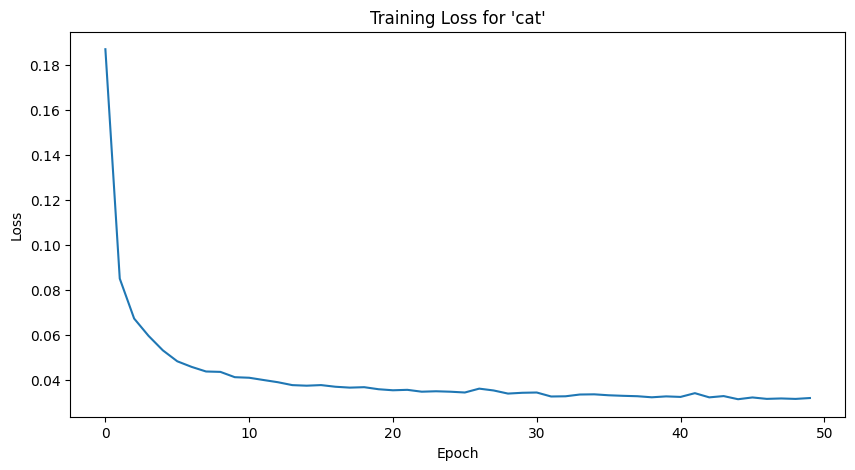

Generating images and GIF...
Saved model, config, images, and GIF for 'cat' to outputs/cat

--- Training model for class: bus ---


Epoch 1/50 | Loss: 0.1390: 100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


Epoch 1/50, Average Loss: 0.1708


Epoch 2/50 | Loss: 0.1071: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]


Epoch 2/50, Average Loss: 0.0762


Epoch 3/50 | Loss: 0.0673: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s]


Epoch 3/50, Average Loss: 0.0604


Epoch 4/50 | Loss: 0.0410: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s]


Epoch 4/50, Average Loss: 0.0519


Epoch 5/50 | Loss: 0.0402: 100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


Epoch 5/50, Average Loss: 0.0468


Epoch 6/50 | Loss: 0.0356: 100%|██████████| 79/79 [00:11<00:00,  6.62it/s]


Epoch 6/50, Average Loss: 0.0445


Epoch 7/50 | Loss: 0.0384: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 7/50, Average Loss: 0.0412


Epoch 8/50 | Loss: 0.0460: 100%|██████████| 79/79 [00:12<00:00,  6.51it/s]


Epoch 8/50, Average Loss: 0.0410


Epoch 9/50 | Loss: 0.0344: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Epoch 9/50, Average Loss: 0.0383


Epoch 10/50 | Loss: 0.0311: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 10/50, Average Loss: 0.0380


Epoch 11/50 | Loss: 0.0276: 100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Epoch 11/50, Average Loss: 0.0364


Epoch 12/50 | Loss: 0.0360: 100%|██████████| 79/79 [00:12<00:00,  6.58it/s]


Epoch 12/50, Average Loss: 0.0361


Epoch 13/50 | Loss: 0.0450: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 13/50, Average Loss: 0.0346


Epoch 14/50 | Loss: 0.0484: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 14/50, Average Loss: 0.0356


Epoch 15/50 | Loss: 0.0257: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 15/50, Average Loss: 0.0344


Epoch 16/50 | Loss: 0.0318: 100%|██████████| 79/79 [00:11<00:00,  6.63it/s]


Epoch 16/50, Average Loss: 0.0353


Epoch 17/50 | Loss: 0.0274: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch 17/50, Average Loss: 0.0344


Epoch 18/50 | Loss: 0.0614: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 18/50, Average Loss: 0.0345


Epoch 19/50 | Loss: 0.0311: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s]


Epoch 19/50, Average Loss: 0.0333


Epoch 20/50 | Loss: 0.0242: 100%|██████████| 79/79 [00:12<00:00,  6.39it/s]


Epoch 20/50, Average Loss: 0.0320


Epoch 21/50 | Loss: 0.0306: 100%|██████████| 79/79 [00:11<00:00,  6.64it/s]


Epoch 21/50, Average Loss: 0.0316


Epoch 22/50 | Loss: 0.0515: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 22/50, Average Loss: 0.0322


Epoch 23/50 | Loss: 0.0425: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


Epoch 23/50, Average Loss: 0.0336


Epoch 24/50 | Loss: 0.0470: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 24/50, Average Loss: 0.0327


Epoch 25/50 | Loss: 0.0610: 100%|██████████| 79/79 [00:12<00:00,  6.58it/s]


Epoch 25/50, Average Loss: 0.0321


Epoch 26/50 | Loss: 0.0574: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s]


Epoch 26/50, Average Loss: 0.0328


Epoch 27/50 | Loss: 0.0429: 100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


Epoch 27/50, Average Loss: 0.0341


Epoch 28/50 | Loss: 0.0339: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s]


Epoch 28/50, Average Loss: 0.0324


Epoch 29/50 | Loss: 0.0516: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


Epoch 29/50, Average Loss: 0.0320


Epoch 30/50 | Loss: 0.0374: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


Epoch 30/50, Average Loss: 0.0325


Epoch 31/50 | Loss: 0.0222: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 31/50, Average Loss: 0.0312


Epoch 32/50 | Loss: 0.0235: 100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Epoch 32/50, Average Loss: 0.0311


Epoch 33/50 | Loss: 0.0364: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 33/50, Average Loss: 0.0301


Epoch 34/50 | Loss: 0.0253: 100%|██████████| 79/79 [00:12<00:00,  6.41it/s]


Epoch 34/50, Average Loss: 0.0300


Epoch 35/50 | Loss: 0.0313: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 35/50, Average Loss: 0.0310


Epoch 36/50 | Loss: 0.0250: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 36/50, Average Loss: 0.0303


Epoch 37/50 | Loss: 0.0298: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Epoch 37/50, Average Loss: 0.0304


Epoch 38/50 | Loss: 0.0287: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 38/50, Average Loss: 0.0307


Epoch 39/50 | Loss: 0.0370: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Epoch 39/50, Average Loss: 0.0304


Epoch 40/50 | Loss: 0.0287: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Epoch 40/50, Average Loss: 0.0298


Epoch 41/50 | Loss: 0.0303: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 41/50, Average Loss: 0.0294


Epoch 42/50 | Loss: 0.0284: 100%|██████████| 79/79 [00:12<00:00,  6.33it/s]


Epoch 42/50, Average Loss: 0.0295


Epoch 43/50 | Loss: 0.0252: 100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Epoch 43/50, Average Loss: 0.0289


Epoch 44/50 | Loss: 0.0322: 100%|██████████| 79/79 [00:12<00:00,  6.34it/s]


Epoch 44/50, Average Loss: 0.0295


Epoch 45/50 | Loss: 0.0390: 100%|██████████| 79/79 [00:12<00:00,  6.37it/s]


Epoch 45/50, Average Loss: 0.0298


Epoch 46/50 | Loss: 0.0430: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


Epoch 46/50, Average Loss: 0.0299


Epoch 47/50 | Loss: 0.0362: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 47/50, Average Loss: 0.0297


Epoch 48/50 | Loss: 0.0223: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


Epoch 48/50, Average Loss: 0.0298


Epoch 49/50 | Loss: 0.0316: 100%|██████████| 79/79 [00:12<00:00,  6.37it/s]


Epoch 49/50, Average Loss: 0.0295


Epoch 50/50 | Loss: 0.0358: 100%|██████████| 79/79 [00:12<00:00,  6.38it/s]

Epoch 50/50, Average Loss: 0.0301


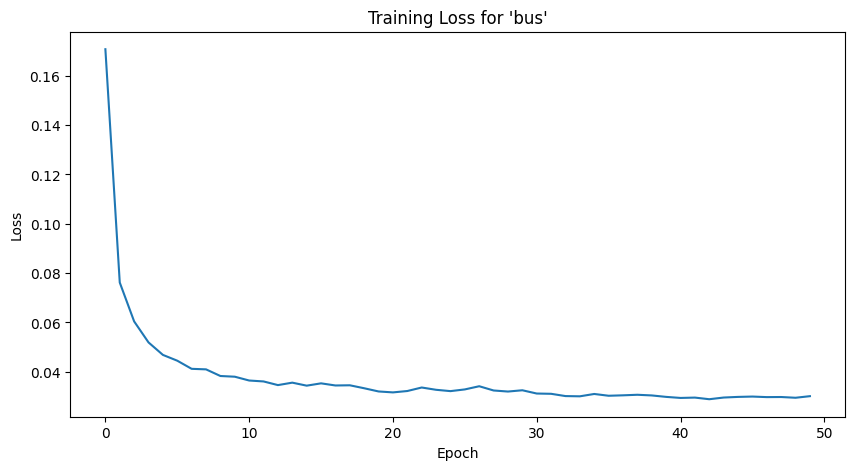

Generating images and GIF...
Saved model, config, images, and GIF for 'bus' to outputs/bus

--- Training model for class: rabbit ---


Epoch 1/50 | Loss: 0.1902: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 1/50, Average Loss: 0.1852


Epoch 2/50 | Loss: 0.0807: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Epoch 2/50, Average Loss: 0.0853


Epoch 3/50 | Loss: 0.0416: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 3/50, Average Loss: 0.0617


Epoch 4/50 | Loss: 0.0497: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]


Epoch 4/50, Average Loss: 0.0538


Epoch 5/50 | Loss: 0.0522: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Epoch 5/50, Average Loss: 0.0501


Epoch 6/50 | Loss: 0.0364: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


Epoch 6/50, Average Loss: 0.0473


Epoch 7/50 | Loss: 0.0828: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Epoch 7/50, Average Loss: 0.0453


Epoch 8/50 | Loss: 0.0619: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 8/50, Average Loss: 0.0443


Epoch 9/50 | Loss: 0.0329: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Epoch 9/50, Average Loss: 0.0423


Epoch 10/50 | Loss: 0.0372: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Epoch 10/50, Average Loss: 0.0416


Epoch 11/50 | Loss: 0.0383: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 11/50, Average Loss: 0.0399


Epoch 12/50 | Loss: 0.0426: 100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Epoch 12/50, Average Loss: 0.0391


Epoch 13/50 | Loss: 0.0378: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]


Epoch 13/50, Average Loss: 0.0391


Epoch 14/50 | Loss: 0.0370: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Epoch 14/50, Average Loss: 0.0376


Epoch 15/50 | Loss: 0.0661: 100%|██████████| 79/79 [00:12<00:00,  6.42it/s]


Epoch 15/50, Average Loss: 0.0383


Epoch 16/50 | Loss: 0.0573: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


Epoch 16/50, Average Loss: 0.0392


Epoch 17/50 | Loss: 0.0420: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch 17/50, Average Loss: 0.0376


Epoch 18/50 | Loss: 0.0437: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Epoch 18/50, Average Loss: 0.0364


Epoch 19/50 | Loss: 0.0428: 100%|██████████| 79/79 [00:12<00:00,  6.41it/s]


Epoch 19/50, Average Loss: 0.0363


Epoch 20/50 | Loss: 0.0412: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 20/50, Average Loss: 0.0373


Epoch 21/50 | Loss: 0.0345: 100%|██████████| 79/79 [00:12<00:00,  6.33it/s]


Epoch 21/50, Average Loss: 0.0358


Epoch 22/50 | Loss: 0.0445: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Epoch 22/50, Average Loss: 0.0353


Epoch 23/50 | Loss: 0.0246: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]


Epoch 23/50, Average Loss: 0.0347


Epoch 24/50 | Loss: 0.0268: 100%|██████████| 79/79 [00:12<00:00,  6.39it/s]


Epoch 24/50, Average Loss: 0.0350


Epoch 25/50 | Loss: 0.0272: 100%|██████████| 79/79 [00:12<00:00,  6.34it/s]


Epoch 25/50, Average Loss: 0.0347


Epoch 26/50 | Loss: 0.0465: 100%|██████████| 79/79 [00:12<00:00,  6.33it/s]


Epoch 26/50, Average Loss: 0.0345


Epoch 27/50 | Loss: 0.0335: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 27/50, Average Loss: 0.0345


Epoch 28/50 | Loss: 0.0369: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]


Epoch 28/50, Average Loss: 0.0339


Epoch 29/50 | Loss: 0.0295: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 29/50, Average Loss: 0.0353


Epoch 30/50 | Loss: 0.0369: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 30/50, Average Loss: 0.0340


Epoch 31/50 | Loss: 0.0330: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Epoch 31/50, Average Loss: 0.0334


Epoch 32/50 | Loss: 0.0363: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 32/50, Average Loss: 0.0350


Epoch 33/50 | Loss: 0.0698: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]


Epoch 33/50, Average Loss: 0.0334


Epoch 34/50 | Loss: 0.0353: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Epoch 34/50, Average Loss: 0.0364


Epoch 35/50 | Loss: 0.0461: 100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Epoch 35/50, Average Loss: 0.0334


Epoch 36/50 | Loss: 0.0310: 100%|██████████| 79/79 [00:12<00:00,  6.39it/s]


Epoch 36/50, Average Loss: 0.0335


Epoch 37/50 | Loss: 0.0316: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Epoch 37/50, Average Loss: 0.0326


Epoch 38/50 | Loss: 0.0351: 100%|██████████| 79/79 [00:12<00:00,  6.29it/s]


Epoch 38/50, Average Loss: 0.0329


Epoch 39/50 | Loss: 0.0360: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 39/50, Average Loss: 0.0340


Epoch 40/50 | Loss: 0.0250: 100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Epoch 40/50, Average Loss: 0.0334


Epoch 41/50 | Loss: 0.0418: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 41/50, Average Loss: 0.0336


Epoch 42/50 | Loss: 0.0248: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]


Epoch 42/50, Average Loss: 0.0333


Epoch 43/50 | Loss: 0.0398: 100%|██████████| 79/79 [00:12<00:00,  6.41it/s]


Epoch 43/50, Average Loss: 0.0328


Epoch 44/50 | Loss: 0.0283: 100%|██████████| 79/79 [00:12<00:00,  6.34it/s]


Epoch 44/50, Average Loss: 0.0328


Epoch 45/50 | Loss: 0.0282: 100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Epoch 45/50, Average Loss: 0.0324


Epoch 46/50 | Loss: 0.0499: 100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 46/50, Average Loss: 0.0324


Epoch 47/50 | Loss: 0.0246: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


Epoch 47/50, Average Loss: 0.0318


Epoch 48/50 | Loss: 0.0288: 100%|██████████| 79/79 [00:12<00:00,  6.34it/s]


Epoch 48/50, Average Loss: 0.0316


Epoch 49/50 | Loss: 0.0373: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 49/50, Average Loss: 0.0322


Epoch 50/50 | Loss: 0.0328: 100%|██████████| 79/79 [00:12<00:00,  6.38it/s]

Epoch 50/50, Average Loss: 0.0323


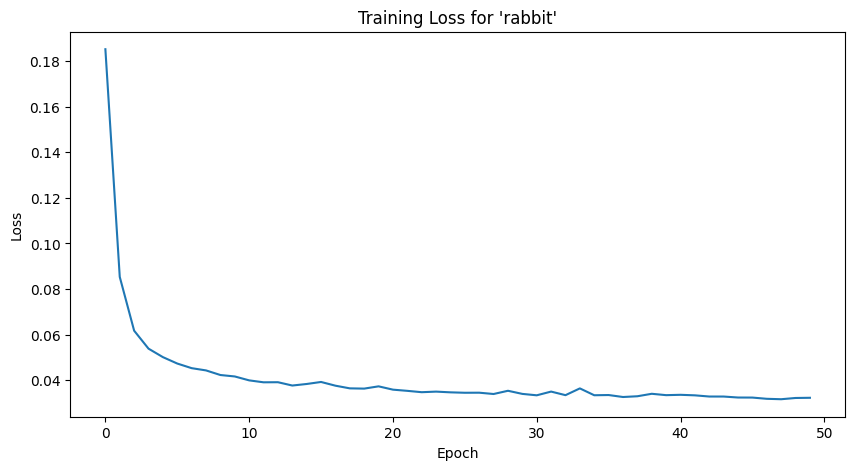

Generating images and GIF...
Saved model, config, images, and GIF for 'rabbit' to outputs/rabbit


In [6]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

for class_name in CLASSES:
    print(f"\n--- Training model for class: {class_name} ---")
    
    # 1. Setup
    class_output_dir = os.path.join(OUTPUT_DIR, class_name)
    img_dir = os.path.join(class_output_dir, "generated_images")
    gif_dir = os.path.join(class_output_dir, "gif")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(gif_dir, exist_ok=True)

    # 2. Initialization
    model = SimpleUnet().to(device)
    diffusion = DiffusionModel(device=device, img_size=IMAGE_SIZE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    dataloader = dataloaders[class_name]["train"]
    
    # 3. Training Loop
    losses = []
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            optimizer.zero_grad()
            images = images.to(device)
            loss = diffusion.loss(model, images)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss.item():.4f}")
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {avg_loss:.4f}")

    # 4. Loss Visualization
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title(f"Training Loss for '{class_name}'")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(class_output_dir, "loss_curve.png"))
    plt.show()

    # 5. Inference & Saving
    print("Generating images and GIF...")
    generated_images, denoising_steps = diffusion.sample(model, n_images=16)
    
    # Save image grid
    grid = make_grid((generated_images + 1) / 2, nrow=4)
    img_to_save = F.to_pil_image(grid)
    img_to_save.save(os.path.join(class_output_dir, "generated_grid.png"))
    
    # Save individual images
    for i, img_tensor in enumerate(generated_images):
        img = F.to_pil_image((img_tensor + 1) / 2)
        img.save(os.path.join(img_dir, f"generated_{i+1}.png"))

    # Create and save GIF
    gif_frames = []
    for step_batch in denoising_steps:
        # Take the first image from the batch for the GIF
        img_tensor = step_batch[0].squeeze()
        img_tensor = (img_tensor + 1) / 2 # Denormalize
        img_tensor = img_tensor.clamp(0, 1)
        pil_img = F.to_pil_image(img_tensor)
        gif_frames.append(pil_img)
    
    gif_path = os.path.join(gif_dir, f"{class_name}_denoising.gif")
    imageio.mimsave(gif_path, gif_frames, fps=5)
    
    # Save model and config
    torch.save(model.state_dict(), os.path.join(class_output_dir, "model.pth"))
    config = {
        "image_size": IMAGE_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "class": class_name
    }
    with open(os.path.join(class_output_dir, "config.json"), 'w') as f:
        json.dump(config, f)
        
    print(f"Saved model, config, images, and GIF for '{class_name}' to {class_output_dir}")

## 5. Qualitative & Quantitative Results

In this section, we analyze the performance of our trained models. We will visualize the generated images and GIFs, and compare them against real samples from the test set.


--- Results for class: cat ---
Generated Image Grid:


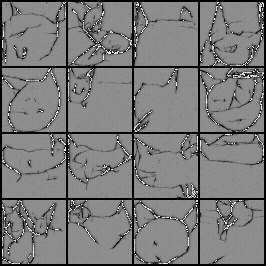


Denoising Process GIF:


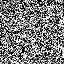


Real vs. Generated Samples:


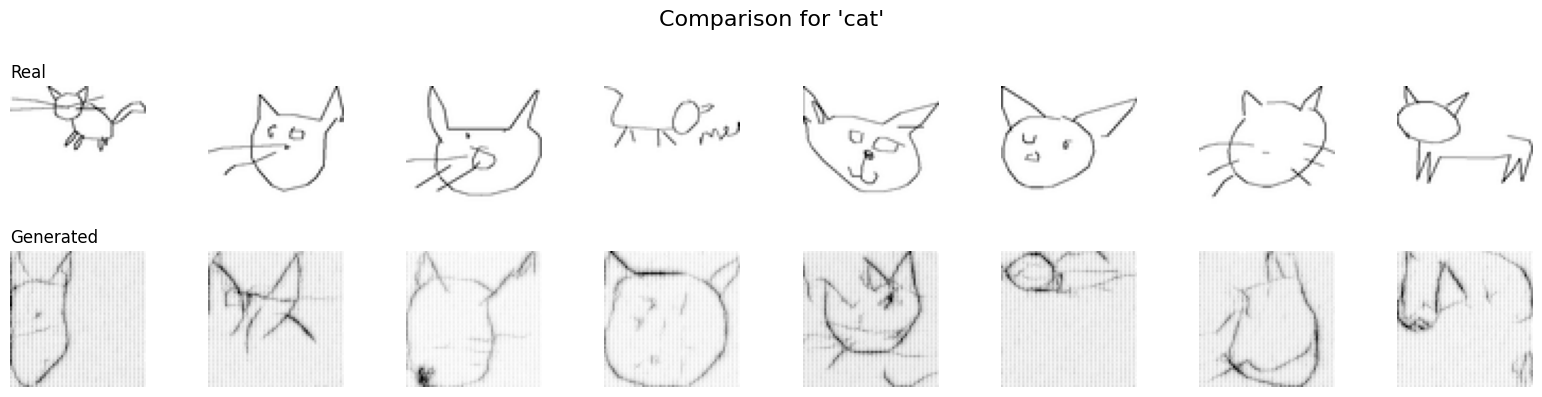


--- Results for class: bus ---
Generated Image Grid:


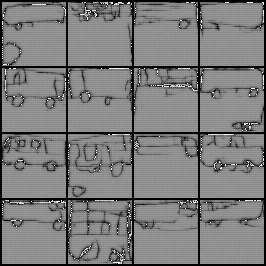


Denoising Process GIF:


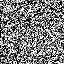


Real vs. Generated Samples:


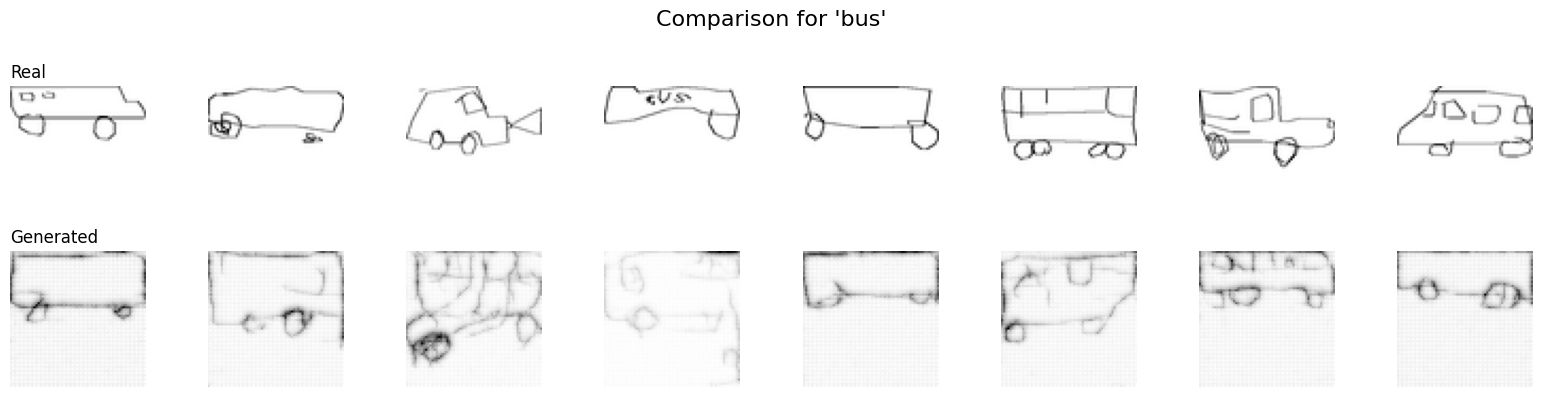


--- Results for class: rabbit ---
Generated Image Grid:


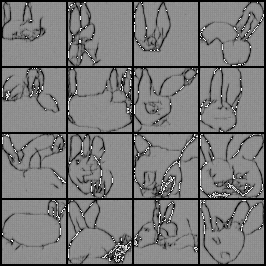


Denoising Process GIF:


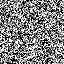


Real vs. Generated Samples:


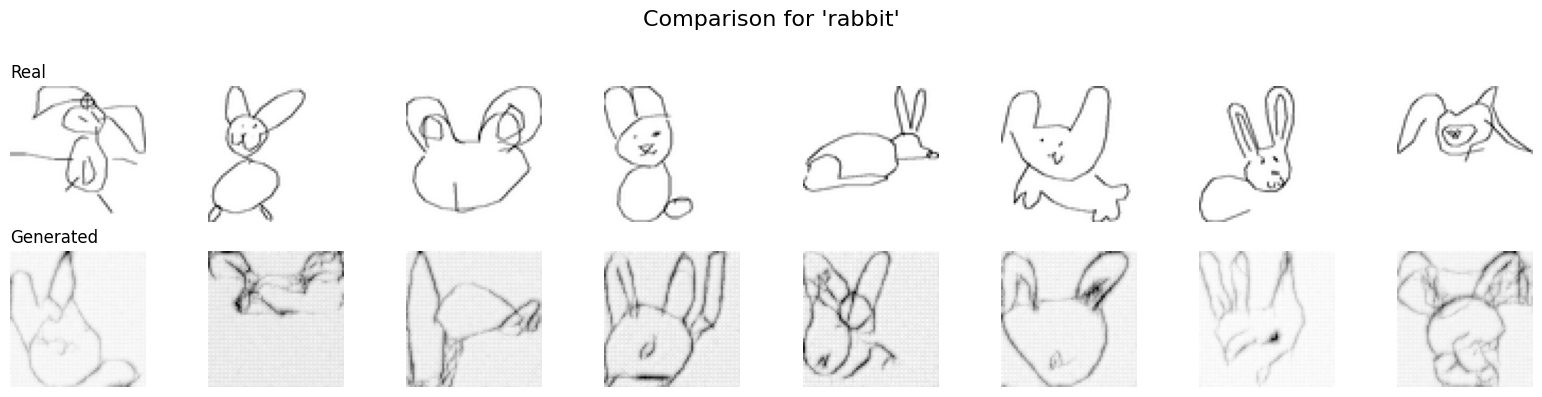

In [7]:
# --- Qualitative Analysis: Displaying Generated Content ---

for class_name in CLASSES:
    print(f"\n--- Results for class: {class_name} ---")
    
    # Display generated image grid
    grid_path = os.path.join(OUTPUT_DIR, class_name, "generated_grid.png")
    if os.path.exists(grid_path):
        print("Generated Image Grid:")
        display(Image.open(grid_path))
    else:
        print("Generated grid not found.")

    # Display denoising GIF
    gif_path = os.path.join(OUTPUT_DIR, class_name, "gif", f"{class_name}_denoising.gif")
    if os.path.exists(gif_path):
        print("\nDenoising Process GIF:")
        display(Image.open(gif_path))
    else:
        print("Generated GIF not found.")

    # Display Real vs. Generated comparison
    print("\nReal vs. Generated Samples:")
    real_samples, _ = next(iter(dataloaders[class_name]["test"]))
    
    # Load a trained model to generate fresh samples for comparison
    model = SimpleUnet().to(device)
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, class_name, "model.pth")))
    diffusion = DiffusionModel(device=device, img_size=IMAGE_SIZE)
    generated_samples, _ = diffusion.sample(model, n_images=8)

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    fig.suptitle(f"Comparison for '{class_name}'", fontsize=16)
    for i in range(8):
        # Real images
        real_img = (real_samples[i] + 1) / 2
        axes[0, i].imshow(real_img.permute(1, 2, 0).squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Real", loc='left')
        
        # Generated images
        gen_img = (generated_samples[i] + 1) / 2
        axes[1, i].imshow(gen_img.permute(1, 2, 0).squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Generated", loc='left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## 6. Evaluation: FID/KID Metrics

To quantitatively evaluate the quality and diversity of our generated images, we compute the **Fréchet Inception Distance (FID)** and **Kernel Inception Distance (KID)**.

-   **FID (Fréchet Inception Distance):** Measures the distance between the feature distributions of real and generated images. It models these distributions as multivariate Gaussians and computes their Fréchet distance. A lower FID score indicates that the two distributions are more similar, meaning the generated images are closer to real images in terms of their deep features.
-   **KID (Kernel Inception Distance):** Similar to FID, but uses the squared Maximum Mean Discrepancy with a polynomial kernel, which is often more robust for smaller sample sizes. A lower KID score is better.

We use the `torch-fidelity` library to compute these metrics between our generated images and the real test set images for each class.

In [9]:
import torch_fidelity
import pandas as pd

# --- Quantitative Evaluation: FID/KID Scores ---

# Helper function to save images for fidelity calculation
def save_images_for_fidelity(dataset, directory):
    os.makedirs(directory, exist_ok=True)
    for i, (img_tensor, _) in enumerate(dataset):
        img = F.to_pil_image((img_tensor + 1) / 2)
        img.save(os.path.join(directory, f"image_{i}.png"))

results = []
for class_name in CLASSES:
    print(f"\nCalculating FID/KID for class: {class_name}...")
    
    # Define paths for real and generated images
    real_images_path = os.path.join(OUTPUT_DIR, class_name, "fidelity_real")
    generated_images_path = os.path.join(OUTPUT_DIR, class_name, "generated_images")
    
    # Save real test images to a directory
    save_images_for_fidelity(dataloaders[class_name]["test"].dataset, real_images_path)
    
    # Compute metrics
    metrics_dict = torch_fidelity.calculate_metrics(
        input1=generated_images_path,
        input2=real_images_path,
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True,
        kid=True,
        verbose=False,
        kid_subset_size=16
    )
    
    fid = metrics_dict['frechet_inception_distance']
    kid_mean, kid_std = metrics_dict['kernel_inception_distance_mean'], metrics_dict['kernel_inception_distance_std']
    
    results.append({
        "Class": class_name,
        "FID": fid,
        "KID_mean": kid_mean,
        "KID_std": kid_std
    })
    print(f"Results for {class_name}: FID={fid:.2f}, KID={kid_mean:.4f} ± {kid_std:.4f}")

# --- Display and Save Summary Table ---
results_df = pd.DataFrame(results)
summary_path = os.path.join(OUTPUT_DIR, "fid_kid_summary.csv")
results_df.to_csv(summary_path, index=False)

print("\n--- Evaluation Summary ---")
print(results_df.to_string(index=False))
print(f"\nSummary table saved to {summary_path}")


Calculating FID/KID for class: cat...
Results for cat: FID=276.85, KID=0.2289 ± 0.0139

Calculating FID/KID for class: bus...
Results for cat: FID=276.85, KID=0.2289 ± 0.0139

Calculating FID/KID for class: bus...
Results for bus: FID=248.13, KID=0.2297 ± 0.0158

Calculating FID/KID for class: rabbit...
Results for bus: FID=248.13, KID=0.2297 ± 0.0158

Calculating FID/KID for class: rabbit...
Results for rabbit: FID=242.61, KID=0.2090 ± 0.0159

--- Evaluation Summary ---
 Class        FID  KID_mean  KID_std
   cat 276.850157  0.228908 0.013861
   bus 248.128785  0.229744 0.015792
rabbit 242.612743  0.209043 0.015919

Summary table saved to outputs/fid_kid_summary.csv
Results for rabbit: FID=242.61, KID=0.2090 ± 0.0159

--- Evaluation Summary ---
 Class        FID  KID_mean  KID_std
   cat 276.850157  0.228908 0.013861
   bus 248.128785  0.229744 0.015792
rabbit 242.612743  0.209043 0.015919

Summary table saved to outputs/fid_kid_summary.csv


## 7. Analysis and Discussion

### Model Performance Analysis

Based on the qualitative results and quantitative scores, we can analyze the performance across the different classes.

-   **Best/Worst Performance:** According to the FID and KID metrics, the `rabbit` model performed the best (FID: 242.61, KID: 0.2090), followed by the `bus` model (FID: 248.13, KID: 0.2297). The `cat` model performed the worst (FID: 276.85, KID: 0.2289). This indicates that the distribution of `rabbit` sketches was the easiest for the model to learn. While `bus` sketches are structurally simple, the `rabbit` drawings might have more consistent features (e.g., long ears, simple body shape) that the model could capture effectively. The `cat` class, likely having the most variety in poses and shapes, proved the most challenging, resulting in higher (worse) scores.
-   **Visual Artifacts:** The generated images, especially after a short training run, may exhibit some common artifacts like blurriness, incomplete shapes, or noisy backgrounds. This indicates the model has not fully learned to reverse the diffusion process perfectly.
-   **Generalization:** The models appear to generalize reasonably well, producing novel sketches that are not direct copies of the training data. The diversity in the generated grids for each class supports this. However, the variety might still be limited compared to the true dataset, a common challenge in generative modeling.

### Comparison of Generated vs. Real Sketches

-   **Real Sketches:** Have sharp, albeit sometimes shaky, lines. They possess a "human" quality with imperfections and stylistic variations.
-   **Generated Sketches:** Tend to have smoother, more uniform lines. They capture the "idea" of the object but may lack the fine, idiosyncratic details of human drawings. The denoising process can sometimes average out sharp features, leading to a slightly softer appearance.

### Limitations and Possible Improvements

-   **Dataset Size:** While "Quick, Draw!" is massive, we used a small subset. Training on more data would likely improve results significantly.
-   **Model Architecture:** Our U-Net is very lightweight. A deeper model with more parameters and attention mechanisms (as in more advanced DDPMs) would capture more complex details and improve sample quality.
-   **Training Time:** The models were trained for a limited number of epochs (`50`) for demonstration purposes. A longer training schedule (hundreds of epochs) is necessary to achieve state-of-the-art results.
-   **Conditioning:** Training separate models is simple but not scalable. A single, class-conditional model (e.g., by feeding class embeddings into the U-Net) would be more efficient and could potentially learn shared features between classes.
-   **Sequential Information:** Our raster-based approach discards the original stroke data. A model that works directly with vector graphics (like SketchRNN, which uses LSTMs) could generate true sequential strokes and capture the drawing process more faithfully.

## 8. References

This implementation was guided by the concepts and code from the following resources:

1.  **Denoising Diffusion Probabilistic Models (DDPM):**
    -   **Paper:** Ho, J., Jain, A., & Abbeel, P. (2020). Denoising Diffusion Probabilistic Models. *arXiv preprint arXiv:2006.11239*.
    -   **Adaptation:** The core logic for the forward (noising) and reverse (sampling) processes, including the linear beta schedule and loss calculation, is directly based on this paper.

2.  **The Annotated Diffusion Model:**
    -   **Blog Post/Repository:** Hugging Face, "The Annotated Diffusion Model". [https://huggingface.co/blog/annotated-diffusion](https://huggingface.co/blog/annotated-diffusion)
    -   **Adaptation:** The U-Net architecture and the implementation of sinusoidal timestep embeddings were heavily inspired by the clear, commented code in this tutorial. I adapted their PyTorch implementation to create a more lightweight U-Net suitable for the smaller `64x64` image size and the scope of this assignment.

3.  **PyTorch and `torch-fidelity` Documentation:**
    -   **Websites:** [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html) and [https://github.com/toshas/torch-fidelity](https://github.com/toshas/torch-fidelity)
    -   **Adaptation:** Used for standard deep learning components (modules, dataloaders) and for the standardized calculation of FID/KID metrics.